In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
from env import user_name, password, host
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns',None) 
pd.set_option('display.max_rows',None)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

In [2]:
#Acquire

In [3]:
def get_connection(db_name):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    '''
    return f'mysql+pymysql://{user_name}:{password}@{host}/{db_name}'

#Create query to get necessary data
def telco_data():
    '''
    This function reads in the telcoco data from the Codeup db
    and returns a pandas DataFrame with all columns and it was joined with other tables.
    '''
    sql_query = '''
    Select * from customers
    join contract_types on contract_types.contract_type_id = customers.contract_type_id
    join payment_types on payment_types.payment_type_id = customers.payment_type_id
    join internet_service_types on internet_service_types.internet_service_type_id = customers.internet_service_type_id
    '''
    return pd.read_sql(sql_query,get_connection('telco_churn'))

In [4]:
telco_df = telco_data()

In [5]:
telco_df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,contract_type_id,contract_type,payment_type_id,payment_type,internet_service_type_id,internet_service_type
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,1,No,Yes,No,Yes,Yes,No,2,Yes,2,65.6,593.3,No,2,One year,2,Mailed check,1,DSL
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,No,No,No,No,No,Yes,1,No,2,59.9,542.4,No,1,Month-to-month,2,Mailed check,1,DSL
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,2,No,No,Yes,No,No,No,1,Yes,1,73.9,280.85,Yes,1,Month-to-month,1,Electronic check,2,Fiber optic
3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,2,No,Yes,Yes,No,Yes,Yes,1,Yes,1,98.0,1237.85,Yes,1,Month-to-month,1,Electronic check,2,Fiber optic
4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,2,No,No,No,Yes,Yes,No,1,Yes,2,83.9,267.4,Yes,1,Month-to-month,2,Mailed check,2,Fiber optic


In [6]:
telco_df.isna().sum()

customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
internet_service_type_id    0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
contract_type_id            0
paperless_billing           0
payment_type_id             0
monthly_charges             0
total_charges               0
churn                       0
contract_type_id            0
contract_type               0
payment_type_id             0
payment_type                0
internet_service_type_id    0
internet_service_type       0
dtype: int64

In [7]:
#We can see the there are some duplicates columns but threre is no duplicates value
telco_df.duplicated().sum()

0

In [8]:
telco_df.contract_type.value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: contract_type, dtype: int64

In [5]:
telco_df = telco_df.drop_duplicates()
telco_df = telco_df.drop(columns = ['customer_id','internet_service_type_id','payment_type_id','contract_type_id'])
telco_df['total_charges'] = telco_df.total_charges.replace(' ', '0').astype(float)

In [10]:
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 7043 non-null   object 
 1   senior_citizen         7043 non-null   int64  
 2   partner                7043 non-null   object 
 3   dependents             7043 non-null   object 
 4   tenure                 7043 non-null   int64  
 5   phone_service          7043 non-null   object 
 6   multiple_lines         7043 non-null   object 
 7   online_security        7043 non-null   object 
 8   online_backup          7043 non-null   object 
 9   device_protection      7043 non-null   object 
 10  tech_support           7043 non-null   object 
 11  streaming_tv           7043 non-null   object 
 12  streaming_movies       7043 non-null   object 
 13  paperless_billing      7043 non-null   object 
 14  monthly_charges        7043 non-null   float64
 15  tota

In [6]:
#Need to drop some columns before create a dummy
cols = list(telco_df.select_dtypes('object').columns)

In [12]:
cols

['gender',
 'partner',
 'dependents',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'churn',
 'contract_type',
 'payment_type',
 'internet_service_type']

In [7]:
dummy_df = pd.get_dummies(telco_df[cols],dummy_na=False, drop_first=True)

In [8]:
dummy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                                 Non-Null Count  Dtype
---  ------                                 --------------  -----
 0   gender_Male                            7043 non-null   uint8
 1   partner_Yes                            7043 non-null   uint8
 2   dependents_Yes                         7043 non-null   uint8
 3   phone_service_Yes                      7043 non-null   uint8
 4   multiple_lines_No phone service        7043 non-null   uint8
 5   multiple_lines_Yes                     7043 non-null   uint8
 6   online_security_No internet service    7043 non-null   uint8
 7   online_security_Yes                    7043 non-null   uint8
 8   online_backup_No internet service      7043 non-null   uint8
 9   online_backup_Yes                      7043 non-null   uint8
 10  device_protection_No internet service  7043 non-null   uint8
 11  device_protection_Yes         

In [9]:
dummy_df = dummy_df.drop(columns = ['multiple_lines_No phone service',
                                    'online_backup_No internet service',
                                    'online_security_No internet service',
                                    'device_protection_No internet service',
                                    'tech_support_No internet service',
                                    'streaming_tv_No internet service',
                                    'streaming_movies_No internet service'])

In [10]:
dummy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   gender_Male                           7043 non-null   uint8
 1   partner_Yes                           7043 non-null   uint8
 2   dependents_Yes                        7043 non-null   uint8
 3   phone_service_Yes                     7043 non-null   uint8
 4   multiple_lines_Yes                    7043 non-null   uint8
 5   online_security_No internet service   7043 non-null   uint8
 6   online_security_Yes                   7043 non-null   uint8
 7   online_backup_Yes                     7043 non-null   uint8
 8   device_protection_Yes                 7043 non-null   uint8
 9   tech_support_Yes                      7043 non-null   uint8
 10  streaming_tv_Yes                      7043 non-null   uint8
 11  streaming_movies_Yes                  7043 

In [37]:
dummy_df.head()

,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_Yes,paperless_billing_Yes,churn_Yes,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None
0,0,1,0,1,1,0,0,1,1,1,0,1,0,0,1,0,0,0,0,1,1,0,0
1,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0
2,0,0,1,0,0,0,1,0,0,1,0,1,1,1,0,0,0,0,1,0,0,1,0
3,0,1,1,0,1,1,1,1,0,1,0,1,1,1,0,0,0,0,1,0,0,1,0
4,0,0,0,1,1,0,0,1,0,1,0,1,1,1,0,0,0,0,0,1,0,1,0


In [11]:
telco_df = pd.concat([telco_df, dummy_df], axis=1)

In [12]:
telco_df.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,payment_type,internet_service_type,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_Yes,online_security_No internet service,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,contract_type_One year,contract_type_Two year,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,internet_service_type_Fiber optic,internet_service_type_None
0,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,Yes,Yes,No,Yes,65.6,593.30,No,One year,Mailed check,DSL,0,1,1,1,0,0,0,1,0,1,1,0,1,0,1,0,0,0,1,0,0
1,Male,0,No,No,9,Yes,Yes,No,No,No,No,No,Yes,No,59.9,542.40,No,Month-to-month,Mailed check,DSL,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,Male,0,No,No,4,Yes,No,No,No,Yes,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Electronic check,Fiber optic,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,1,0
3,Male,1,Yes,No,13,Yes,No,No,Yes,Yes,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Electronic check,Fiber optic,1,1,0,1,0,0,0,1,1,0,1,1,1,1,0,0,0,1,0,1,0
4,Female,1,Yes,No,3,Yes,No,No,No,No,Yes,Yes,No,Yes,83.9,267.40,Yes,Month-to-month,Mailed check,Fiber optic,0,1,0,1,0,0,0,0,0,1,1,0,1,1,0,0,0,0,1,1,0


In [13]:
cols

['gender',
 'partner',
 'dependents',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'churn',
 'contract_type',
 'payment_type',
 'internet_service_type']

In [14]:
telco_df.drop(columns=cols, inplace=True)

In [15]:
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   senior_citizen                        7043 non-null   int64  
 1   tenure                                7043 non-null   int64  
 2   monthly_charges                       7043 non-null   float64
 3   total_charges                         7043 non-null   float64
 4   gender_Male                           7043 non-null   uint8  
 5   partner_Yes                           7043 non-null   uint8  
 6   dependents_Yes                        7043 non-null   uint8  
 7   phone_service_Yes                     7043 non-null   uint8  
 8   multiple_lines_Yes                    7043 non-null   uint8  
 9   online_security_No internet service   7043 non-null   uint8  
 10  online_security_Yes                   7043 non-null   uint8  
 11  online_backup_Yes

In [ ]:
#Cleaning

In [5]:
def clean_data(df):
    '''
    This function will drop uneccessary columns or duplicates that is not useful for analysis.  
    change total_charges from object type to a float type. 
    create dummy variables for telco data that have the object type columns and then join with it original telco dataframe. 
    after joining, drop the columns that used to create dummy dataframe.
    and then return original telco dataframe.
    '''

    #Clean data

    #Drop duplicate rows, if present
    df = df.drop_duplicates()
    #Drop most of id columns since it is not useful in analysis
    df = df.drop(columns = ['customer_id','internet_service_type_id','payment_type_id','contract_type_id'])

    #Conver total_charges to float
    df['total_charges'] = df.total_charges.replace(' ', '0').astype(float)
    
    #Create a dummy df
    col_list = list(df.select_dtypes('object').columns)

    #Create a dummy df and then 
    #create a loop to make it look through the list above
    #then drop some drops that is repeatedly
    for col in col_list:
        dummy_df = pd.get_dummies(telco_df[col_list],dummy_na=False, drop_first=True)
        dummy_df = dummy_df.drop(columns = ['multiple_lines_No phone service',
                                    'online_backup_No internet service',
                                    'online_security_No internet service',
                                    'device_protection_No internet service',
                                    'tech_support_No internet service',
                                    'streaming_tv_No internet service',
                                    'streaming_movies_No internet service'])
        
    #Concatenate the dummy_df dataframe above with the original df
    df = pd.concat([df, dummy_df], axis=1)
    #Drop the columns that we already use to create dummy_df
    df.drop(columns=col_list, inplace=True)
    
    #Rename columns so more its meaningful 
    df = df.rename(columns={'contract_type_One year':'one_year',
                            'contract_type_Two year':'two_year',
                            'payment_type_Credit card (automatic)':'credit_card',
                            'payment_type_Electronic check':'electronic_check',
                            'payment_type_Mailed check':'mailed_check',
                            'internet_service_type_Fiber optic':'fiber_optic',
                            'internet_service_type_None':'no_internet_service'})
    
    return df

In [6]:
def split_data(df):
    '''
    This function takes in a dataframe and split the data into 3: train, validate and test
    Establish train+validate set 80% of original data and then repeat the process 
    Split train+validate  into train, validate separately 
    '''
    train_validate, test = train_test_split(df, 
                                            test_size=.2, 
                                            random_state=123, 
                                            stratify=df.churn_Yes)

    train, validate = train_test_split(train_validate, 
                                       test_size=.3, 
                                       random_state=123, 
                                       stratify=train_validate.churn_Yes)
    return train, validate, test

In [7]:
telco_df = clean_data(telco_df)
telco_df.head()

,senior_citizen,tenure,monthly_charges,total_charges,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_Yes,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,one_year,two_year,credit_card,electronic_check,mailed_check,fiber_optic,no_internet_service
0,0,9,65.6,593.30,0,1,1,1,0,0,1,0,1,1,0,1,0,1,0,0,0,1,0,0
1,0,9,59.9,542.40,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,0,4,73.9,280.85,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,1,0
3,1,13,98.0,1237.85,1,1,0,1,0,0,1,1,0,1,1,1,1,0,0,0,1,0,1,0
4,1,3,83.9,267.40,0,1,0,1,0,0,0,0,1,1,0,1,1,0,0,0,0,1,1,0


In [8]:
#Might need to consider drop some columns like  
#online_security_with_no_internet service, device_protection_with_no_internet service,......
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   senior_citizen         7043 non-null   int64  
 1   tenure                 7043 non-null   int64  
 2   monthly_charges        7043 non-null   float64
 3   total_charges          7043 non-null   float64
 4   gender_Male            7043 non-null   uint8  
 5   partner_Yes            7043 non-null   uint8  
 6   dependents_Yes         7043 non-null   uint8  
 7   phone_service_Yes      7043 non-null   uint8  
 8   multiple_lines_Yes     7043 non-null   uint8  
 9   online_security_Yes    7043 non-null   uint8  
 10  online_backup_Yes      7043 non-null   uint8  
 11  device_protection_Yes  7043 non-null   uint8  
 12  tech_support_Yes       7043 non-null   uint8  
 13  streaming_tv_Yes       7043 non-null   uint8  
 14  streaming_movies_Yes   7043 non-null   uint8  
 15  pape

In [9]:
train, validate, test = split_data(telco_df)

In [16]:
print('train shape    :',train.shape)
print('validate shape :',validate.shape)
print('test shape     :',test.shape)

train shape    : (3943, 24)
validate shape : (1691, 24)
test shape     : (1409, 24)


In [17]:
#Explore

In [19]:
telco_df.churn_Yes.value_counts()

0    5174
1    1869
Name: churn_Yes, dtype: int64

In [23]:
churn_rate = train['churn_Yes'].mean()

In [24]:
print(f'Churn rate: {churn_rate:.2%}')

Churn rate: 26.53%


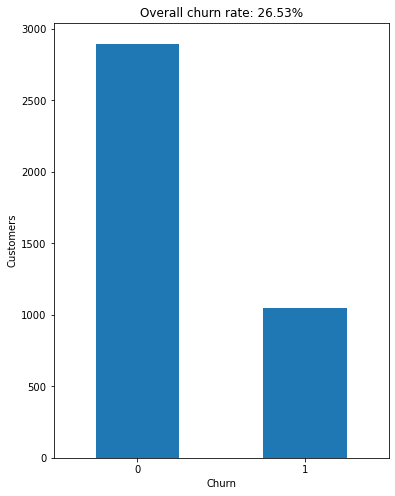

In [25]:
#Try to put this in a function
df = train.churn_Yes.value_counts()
plt.figure(figsize=(6,8))
df.plot.bar(rot = 0)
plt.title(f"Overall churn rate: {churn_rate:.2%}")
plt.xlabel('Churn')
plt.ylabel('Customers')
plt.show()

In [24]:
def churn_bar(df):
    df = df.churn_Yes.value_counts()
    plt.figure(figsize=(6,8))
    df.plot.bar(rot = 0)
    plt.title(f"Overall churn rate: {churn_rate:.2%}")
    plt.xlabel('Churn')
    plt.ylabel('Customers')

    plt.show()

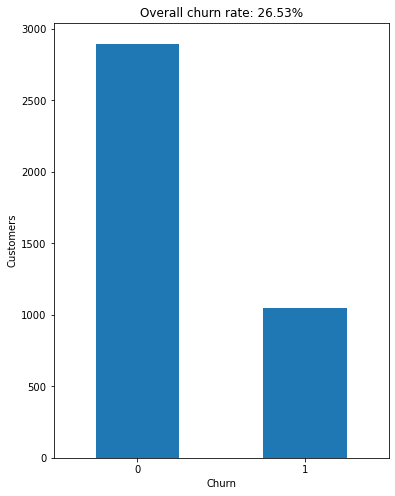

In [25]:
churn_bar(train)

In [26]:
train_corr = train.corr()
train_corr

,senior_citizen,tenure,monthly_charges,total_charges,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_Yes,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,one_year,two_year,credit_card,electronic_check,mailed_check,fiber_optic,no_internet_service
senior_citizen,1.000000,0.021272,0.220297,0.104086,0.004424,0.022743,-0.206147,0.010498,0.141087,-0.027093,0.082438,0.059878,-0.052915,0.108692,0.119603,0.156970,0.137998,-0.037158,-0.119107,-0.026293,0.166820,-0.161532,0.248774,-0.184221
tenure,0.021272,1.000000,0.253502,0.826644,-0.009337,0.385079,0.167668,0.008510,0.330764,0.325176,0.366900,0.370069,0.319004,0.291585,0.273170,0.012484,-0.346061,0.202589,0.559651,0.225430,-0.213188,-0.247185,0.028064,-0.044935
monthly_charges,0.220297,0.253502,1.000000,0.655865,-0.014260,0.111287,-0.116904,0.245734,0.495375,0.309024,0.449610,0.489726,0.336950,0.638746,0.634285,0.348001,0.188742,0.008131,-0.067288,0.020249,0.260878,-0.357010,0.786314,-0.765786
total_charges,0.104086,0.826644,0.655865,1.000000,-0.004626,0.330014,0.069458,0.113085,0.473081,0.416498,0.516631,0.531339,0.423984,0.528560,0.511875,0.157970,-0.190130,0.171972,0.357916,0.174229,-0.067090,-0.295042,0.370207,-0.379117
gender_Male,0.004424,-0.009337,-0.014260,-0.004626,1.000000,-0.018044,-0.005959,-0.005625,-0.003872,-0.019359,-0.007996,0.000400,-0.012149,-0.004126,-0.003723,-0.026466,0.000669,0.002291,-0.019545,0.003325,0.008634,0.026354,-0.017579,0.004759
partner_Yes,0.022743,0.385079,0.111287,0.330014,-0.018044,1.000000,0.450387,0.020379,0.144594,0.144401,0.146022,0.160768,0.134771,0.162712,0.126876,-0.016823,-0.158691,0.096045,0.245930,0.091982,-0.077642,-0.107153,0.002793,-0.008883
dependents_Yes,-0.206147,0.167668,-0.116904,0.069458,-0.005959,0.450387,1.000000,0.006231,-0.021148,0.084476,0.022737,0.016873,0.076896,-0.018500,-0.054415,-0.120217,-0.167771,0.066603,0.217621,0.066259,-0.143641,0.057091,-0.167971,0.150828
phone_service_Yes,0.010498,0.008510,0.245734,0.113085,-0.005625,0.020379,0.006231,1.000000,0.277627,-0.095791,-0.053362,-0.073520,-0.090528,-0.011343,-0.021694,0.009045,0.009568,0.011903,-0.007160,0.000153,-0.001978,0.000385,0.284584,0.167309
multiple_lines_Yes,0.141087,0.330764,0.495375,0.473081,-0.003872,0.144594,-0.021148,0.277627,1.000000,0.094621,0.216400,0.210375,0.093312,0.270546,0.269533,0.165630,0.033437,0.008231,0.092297,0.056589,0.070936,-0.225945,0.367111,-0.218567
online_security_Yes,-0.027093,0.325176,0.309024,0.416498,-0.019359,0.144401,0.084476,-0.095791,0.094621,1.000000,0.287033,0.271512,0.363981,0.194414,0.202366,0.001428,-0.158750,0.082596,0.204253,0.109482,-0.118885,-0.071600,-0.012425,-0.335717


In [61]:
#calculate the correlation of all columns in the train dataset.
train_corr = train.corr()
cols = train_corr['churn_Yes'].sort_values(ascending=False)
cols

churn_Yes                1.000000
fiber_optic              0.304280
electronic_check         0.297440
monthly_charges          0.188742
paperless_billing_Yes    0.188292
senior_citizen           0.137998
streaming_movies_Yes     0.062038
streaming_tv_Yes         0.060303
multiple_lines_Yes       0.033437
phone_service_Yes        0.009568
gender_Male              0.000669
device_protection_Yes   -0.068312
mailed_check            -0.078254
online_backup_Yes       -0.088072
credit_card             -0.126973
tech_support_Yes        -0.150712
partner_Yes             -0.158691
online_security_Yes     -0.158750
dependents_Yes          -0.167771
one_year                -0.180598
total_charges           -0.190130
no_internet_service     -0.222525
two_year                -0.293097
tenure                  -0.346061
baseline                      NaN
Name: churn_Yes, dtype: float64

In [27]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
senior_citizen,3943.0,0.162820,0.369248,0.00,0.000,0.00,0.00,1.00
tenure,3943.0,32.473244,24.551176,0.00,9.000,29.00,55.00,72.00
monthly_charges,3943.0,65.328937,30.261023,18.25,35.900,70.55,90.25,118.75
total_charges,3943.0,2310.297451,2282.121687,0.00,413.125,1404.65,3910.00,8672.45
gender_Male,3943.0,0.509003,0.499982,0.00,0.000,1.00,1.00,1.00
partner_Yes,3943.0,0.486685,0.499886,0.00,0.000,0.00,1.00,1.00
dependents_Yes,3943.0,0.307634,0.461573,0.00,0.000,0.00,1.00,1.00
phone_service_Yes,3943.0,0.907431,0.289864,0.00,1.000,1.00,1.00,1.00
multiple_lines_Yes,3943.0,0.430383,0.495193,0.00,0.000,0.00,1.00,1.00
online_security_Yes,3943.0,0.291149,0.454350,0.00,0.000,0.00,1.00,1.00


<AxesSubplot:>

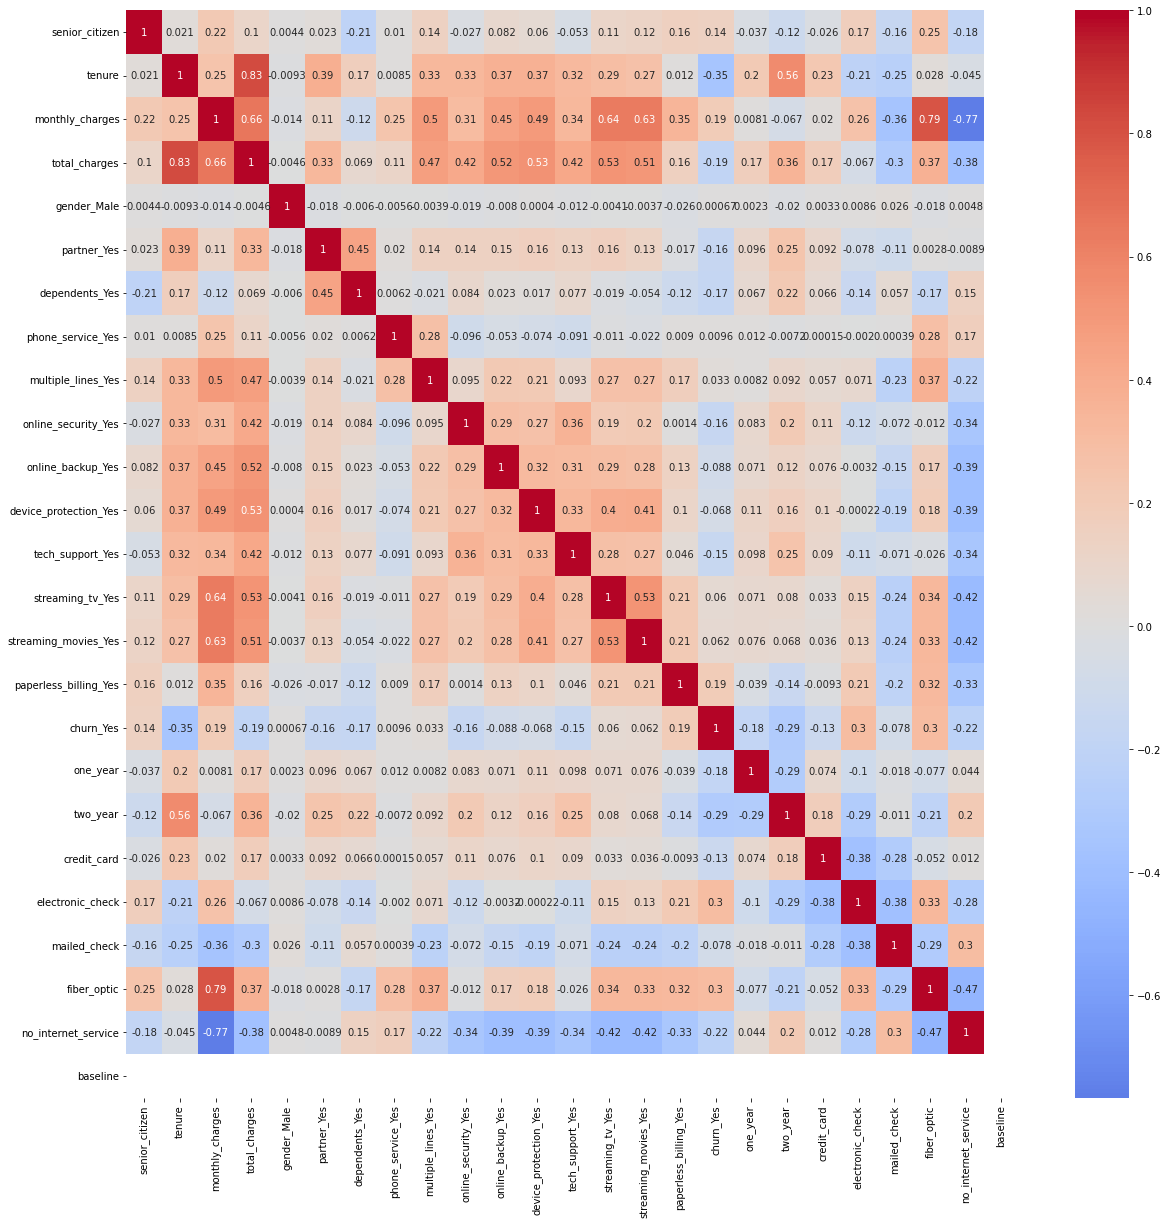

In [62]:
#Try to narrow down more
plt.figure(figsize=(20,20))
sns.heatmap(train.corr() , cmap='coolwarm', center=0, annot=True)

In [63]:
#Checking the columns that has correlation more than -.22
list(cols[cols < (-.18)].index)

['one_year', 'total_charges', 'no_internet_service', 'two_year', 'tenure']

In [64]:
#Same thing as above
list(cols[cols > (.13)].index)

['churn_Yes',
 'fiber_optic',
 'electronic_check',
 'monthly_charges',
 'paperless_billing_Yes',
 'senior_citizen']

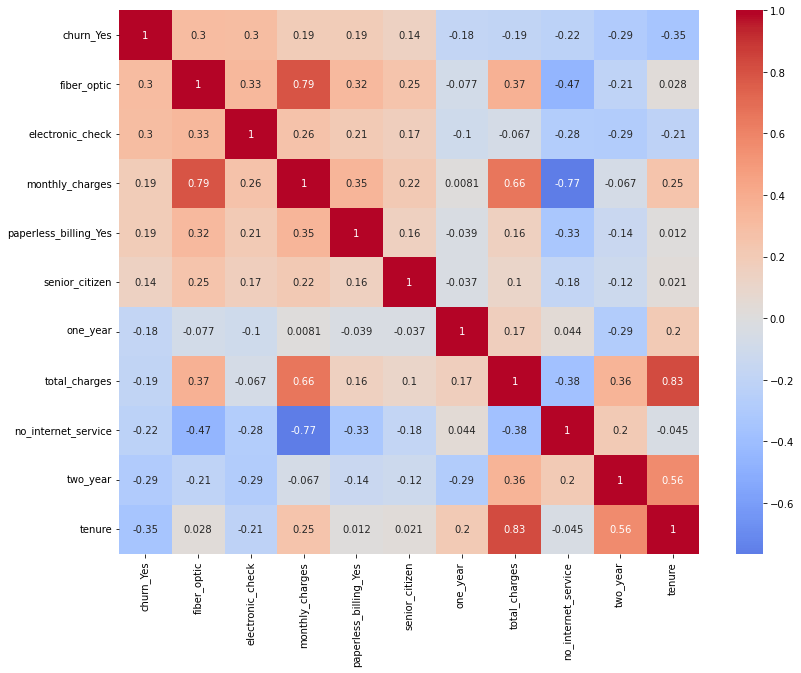

In [65]:
#Little better but still a busy heatmap
#Heatmap is usefull for analysis like this but do not include in a final notebook 
#The end_user might or might not understand the purpose of heatmap like below
col_listf = list(cols[cols > (.13)].index) + list(cols[cols < (-.18)].index)
col_listf

plt.figure(figsize=(13,10))
sns.heatmap(train[col_listf].corr() , cmap='coolwarm', center=0, annot=True)

plt.title('')
plt.show()

Takeaways

churn has positive correlation:

- internet type : fiber_optic
- payment type: electronic check

churn has negative correlation:
- two year
- tenure
- online_security

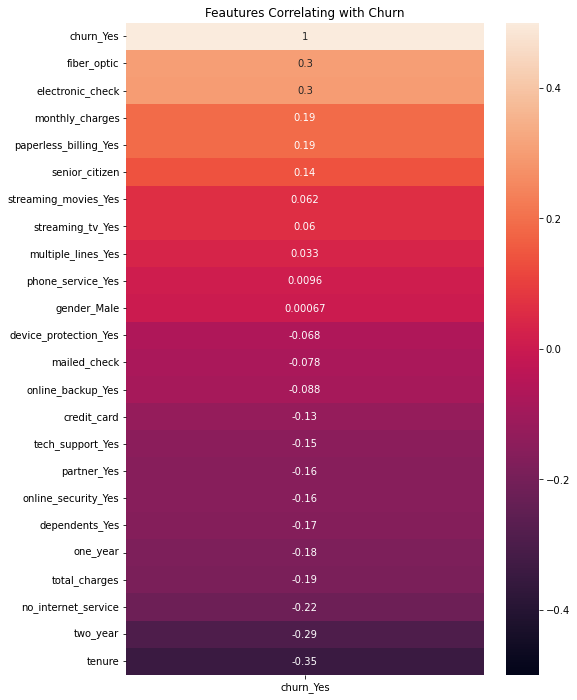

In [47]:
plt.figure(figsize=(8,12))
churn_heatmap = sns.heatmap(train.corr()[['churn_Yes']].sort_values(by='churn_Yes', ascending=False), vmin=-.5, vmax=.5, annot=True)
churn_heatmap.set_title('Feautures Correlating with Churn')
plt.show()

In [45]:
def get_churn_heatmap(df):
    plt.figure(figsize=(8,12))
    churn_heatmap = sns.heatmap(df.corr()[['churn_Yes']].sort_values(by='churn_Yes', ascending=False), vmin=-.5, vmax=.5, annot=True)
    churn_heatmap.set_title('Feautures Correlating with Churn')
    
    return churn_heatmap

<AxesSubplot:title={'center':'Feautures Correlating with Churn'}>

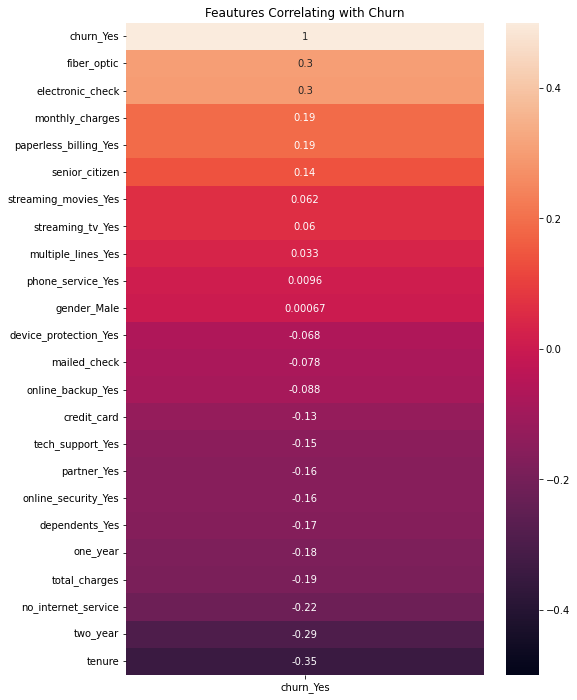

In [46]:
get_churn_heatmap(train)

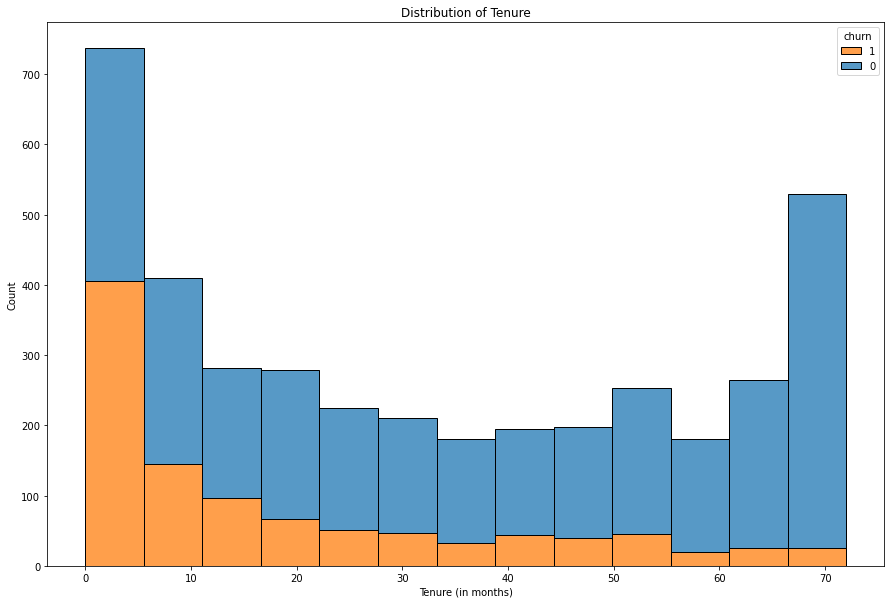

In [58]:
plt.figure(figsize=(15,10))
# Distribution of Tenure
sns.histplot(train,
             x=train.tenure,
             hue='churn_Yes',
             multiple='stack',
             legend=False
             )

plt.title("Distribution of Tenure")
plt.xlabel('Tenure (in months)')
plt.legend(title = 'churn', loc='upper right',labels=[1,0])

In [48]:
#Getting new customers
train[['monthly_charges','total_charges','tenure']][train['total_charges']== 0] 

,monthly_charges,total_charges,tenure
2176,20.25,0.0,0
1731,20.00,0.0,0
945,56.05,0.0,0
4054,80.85,0.0,0
2855,73.35,0.0,0
5433,19.85,0.0,0
3118,52.55,0.0,0
2025,19.70,0.0,0


In [30]:
#Want to know how many customer in the first month
num_customer = train.tenure[train['tenure']== 1].count()
num_customer

333

In [51]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3943 entries, 5310 to 6817
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   senior_citizen         3943 non-null   int64  
 1   tenure                 3943 non-null   int64  
 2   monthly_charges        3943 non-null   float64
 3   total_charges          3943 non-null   float64
 4   gender_Male            3943 non-null   uint8  
 5   partner_Yes            3943 non-null   uint8  
 6   dependents_Yes         3943 non-null   uint8  
 7   phone_service_Yes      3943 non-null   uint8  
 8   multiple_lines_Yes     3943 non-null   uint8  
 9   online_security_Yes    3943 non-null   uint8  
 10  online_backup_Yes      3943 non-null   uint8  
 11  device_protection_Yes  3943 non-null   uint8  
 12  tech_support_Yes       3943 non-null   uint8  
 13  streaming_tv_Yes       3943 non-null   uint8  
 14  streaming_movies_Yes   3943 non-null   uint8  
 15  p

In [53]:
#From the graph above, check how many customer have churned in the first month
first_month = train[['monthly_charges',
                     'tenure', 'churn_Yes','one_year','two_year',
                     'paperless_billing_Yes','credit_card',
                     'mailed_check','electronic_check',
                     'phone_service_Yes','multiple_lines_Yes',
                     'fiber_optic','no_internet_service']][train['tenure']== 1]
first_month.count()

monthly_charges          333
tenure                   333
churn_Yes                333
one_year                 333
two_year                 333
paperless_billing_Yes    333
credit_card              333
mailed_check             333
electronic_check         333
phone_service_Yes        333
multiple_lines_Yes       333
fiber_optic              333
no_internet_service      333
dtype: int64

In [55]:
churned = first_month.churn_Yes[first_month['churn_Yes'] == 1].count()
churned

212

In [34]:
print(f"churn rate in the first month of Tenure: {(churned/num_customer):.2%}")

churn rate in the first month of Tenure: 63.66%


In [14]:
#total of customer tenure = (tenure_less_than-1)
tenure_less_than = 12

ct1 = train.tenure[train['tenure'] <= tenure_less_than].count()
ct1

1212

In [15]:
#create a df with a specific tenure
#cols has specific columns the I want to check
cols = ['monthly_charges',
                     'tenure', 'churn_Yes','one_year','two_year',
                     'paperless_billing_Yes','credit_card',
                     'mailed_check','electronic_check',
                     'phone_service_Yes','multiple_lines_Yes',
                     'fiber_optic','no_internet_service']
df_t1 =train[cols][train['tenure'] <= tenure_less_than ]
df_t1.head()

,monthly_charges,tenure,churn_Yes,one_year,two_year,paperless_billing_Yes,credit_card,mailed_check,electronic_check,phone_service_Yes,multiple_lines_Yes,fiber_optic,no_internet_service
2635,40.05,4,0,0,0,1,0,0,1,0,0,0,0
2986,54.75,8,0,0,0,1,0,1,0,1,0,0,0
1897,95.20,10,1,0,0,0,0,0,1,1,1,1,0
4226,19.35,12,0,1,0,1,0,0,0,1,0,0,1
3053,85.15,6,1,0,0,1,0,0,0,1,0,1,0


In [16]:
df_t1.drop(columns = ['fiber_optic','tenure','phone_service_Yes','multiple_lines_Yes']).sum()

monthly_charges          68101.5
churn_Yes                  571.0
one_year                    78.0
two_year                    35.0
paperless_billing_Yes      721.0
credit_card                130.0
mailed_check               412.0
electronic_check           549.0
no_internet_service        287.0
dtype: float64

In [17]:
#total customer with tenure = custome tenure and churn =1
can = df_t1.churn_Yes[ df_t1['churn_Yes'] == 1].count()
can

571

In [18]:
#create a df and churn =1
churndf = df_t1[(df_t1['churn_Yes']== 1)]
churndf.head()

,monthly_charges,tenure,churn_Yes,one_year,two_year,paperless_billing_Yes,credit_card,mailed_check,electronic_check,phone_service_Yes,multiple_lines_Yes,fiber_optic,no_internet_service
1897,95.20,10,1,0,0,0,0,0,1,1,1,1,0
3053,85.15,6,1,0,0,1,0,0,0,1,0,1,0
6224,83.80,12,1,0,0,1,0,1,0,1,0,1,0
2639,35.05,1,1,0,0,0,0,1,0,0,0,0,0
2508,95.65,8,1,0,0,0,0,0,0,1,1,1,0


In [21]:
churndf.drop(columns = ['electronic_check','no_internet_service','phone_service_Yes','fiber_optic','tenure','multiple_lines_Yes']).sum()

monthly_charges          37439.3
churn_Yes                  571.0
one_year                     7.0
two_year                     0.0
paperless_billing_Yes      406.0
credit_card                 50.0
mailed_check               139.0
dtype: float64

In [28]:
#checking  the customers who have service phone
cols_m = ['multiple_lines_Yes','monthly_charges','fiber_optic', 'electronic_check', 'paperless_billing_Yes','one_year','two_year']
ml_df = churndf[cols_m].groupby('multiple_lines_Yes').sum()
ml_df

,monthly_charges,fiber_optic,electronic_check,paperless_billing_Yes,one_year,two_year
multiple_lines_Yes,,,,,,
0,23232.65,198.0,220.0,263.0,6.0,0.0
1,14206.65,148.0,111.0,143.0,1.0,0.0


In [29]:
#calculate the total of phone service
phone = ml_df.iloc[1:3, 5:].sum().sum()
phone

0.0

In [74]:
only_int = (ml_df.iloc[0, 1:3].sum()).astype(int)

In [27]:
#create a df churn = 1 and tenure < tenure
cols_1v = ['monthly_charges','electronic_check','paperless_billing_Yes', 'one_year','two_year','churn_Yes']
res_df= pd.DataFrame((churndf[cols_1v].sum()),columns=['churn_counts'])
res_df

,churn_counts
monthly_charges,37439.3
electronic_check,331.0
paperless_billing_Yes,406.0
one_year,7.0
two_year,0.0
churn_Yes,571.0


In [76]:
m_char = res_df.iloc[0, 0]

In [77]:
print("")
print("")
print(f'** FIRST {tenure_less_than -1} MONTHS OF TENURE AND CHURN** ')
print("")
print(f'Customers with phone service:         {(phone/can):.2%} ')
print(f'Customers with only internet service: {(only_int/can):.2%} ')
print(f'Monlthy charges: $ {m_char} ')
print("")
print("")



** FIRST 11 MONTHS OF TENURE AND CHURN** 

Customers with phone service:         29.95% 
Customers with only internet service: 60.77% 
Monlthy charges: $ 37439.3 




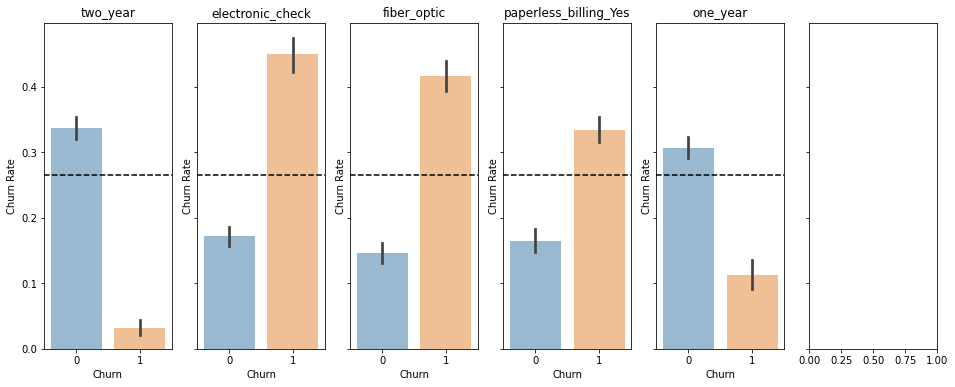

In [30]:
#enumerate() allows us to iterate through a sequence but it keeps track of both the index and the element

features = ['two_year','' 'electronic_check','fiber_optic','paperless_billing_Yes','one_year']


_, ax = plt.subplots(nrows=1, ncols=6, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature,'churn_Yes', data=train, ax=ax[i], alpha=0.5)
    ax[i].set_xlabel('Churn')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='black')

Take Away:
   - We can see a high churned rate on electronic check, paperless_billing, month to month and fiber_optic
   - And customer who has phone service that is one line, has about the same churned rate as the customer didnt churned

# Stats

$H_o$: There is no difference between churn and tenure

$H_a$: There is a difference between churn and tenure

So this will be a t-test

In [35]:
#We set significant level at 5%
α = 0.5
t, p = stats.ttest_1samp(train.tenure, train.churn_Yes.mean())

In [36]:
t,p

(82.37669227970096, 0.0)

In [37]:
if (p < α):
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis




H$o$: Rate of churn is not dependent on Fiber Optic .

H$a$: Rate of churn is dependent on Fiber Optic status.


In [38]:
observed = pd.crosstab(train.fiber_optic, train.churn_Yes)
observed

churn_Yes,0,1
fiber_optic,,
0,1878,320
1,1019,726


In [39]:
chi2, p, degf, expected =stats.chi2_contingency(observed)

In [40]:
print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[1878  320]
 [1019  726]]
---
Expected

[[1614  583]
 [1282  462]]
---

chi^2 = 363.6806
p     = 0.0000


In [41]:
if p < α:
    print('We reject the null Hypothesis')
else:
    print("we fail to reject the null")

We reject the null Hypothesis



H$o$: Rate of churn is not dependent on using auto_pay as the form of payment.

H$a$: Rate of churn is dependent on using auto_pay as the form of payment.


In [42]:
observed2 = pd.crosstab(train.paperless_billing_Yes, train.churn_Yes)
observed2

churn_Yes,0,1
paperless_billing_Yes,,
0,1335,263
1,1562,783


In [43]:
chi2, p, degf, expected =stats.chi2_contingency(observed2)

In [44]:
print('Observed\n')
print(observed2.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[1335  263]
 [1562  783]]
---
Expected

[[1174  423]
 [1722  622]]
---

chi^2 = 138.9267
p     = 0.0000


In [50]:
if p < α:
    print('We reject the null Hypothesis')
else:
    print("we fail to reject the null")

We reject the null Hypothesis


In [105]:
#Modeling

In [107]:
#Look for which value occur the most in churn
#and then set it as a baseline accuracy
train.churn.value_counts().idxmax()

0

In [51]:
train['baseline']= train.churn_Yes.value_counts().idxmax()

In [52]:
#Set the baseline
baseline_acc =(train.baseline == train.churn_Yes).mean()
baseline_acc

0.7347197565305605

In [53]:
print(f'The baseline accuracy for No Churn in all cases on the telco Dataset is {(train.baseline == train.churn_Yes).mean().mean():.3%}')

The baseline accuracy for No Churn in all cases on the telco Dataset is 73.472%


In [103]:
x_col = ['fiber_optic', 'electronic_check', 'monthly_charges', 'tenure', 'two_year']
y_col = 'churn_Yes'

In [104]:
X_train =  train[x_col]
y_train = train[y_col]
X_validate, y_validate = validate[x_col], validate[y_col]
X_test, y_test = test[x_col], test[y_col]

I am trying to predict the customers that will churn so the positive variable will be churn = 1 in my folowing models.`

Possible Outcomes:

TP: Predict customers churn and customers did churn

TN: Predict no customers churn and customers did not churn

FP: Predict customers churn but customer did not churn

FN: Predict no customers churn but customers did churn

### Random Forest 

In [105]:
#col_list have the lsit of columns with the highest correlation (positive and negative)
columns = col_listf[1:] 
columns

['fiber_optic',
 'electronic_check',
 'monthly_charges',
 'paperless_billing_Yes',
 'senior_citizen',
 'one_year',
 'total_charges',
 'no_internet_service',
 'two_year',
 'tenure']

In [106]:
#Create the thing
model_dtl= DecisionTreeClassifier(max_depth=5, max_leaf_nodes = 6)

In [108]:
# fit the model
model_dtl.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=6)

In [109]:
# look at the model scores for training set and validate set
print(f'training score: {model_dtl.score(X_train, y_train):.2%}')
print(f'validate score: {model_dtl.score(X_validate, y_validate):.2%}')

training score: 78.75%
validate score: 79.07%


In [197]:
y_pred = model_dtl.predict(X_train)

In [198]:
#classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      2897
           1       0.68      0.38      0.49      1046

    accuracy                           0.79      3943
   macro avg       0.74      0.66      0.68      3943
weighted avg       0.77      0.79      0.77      3943



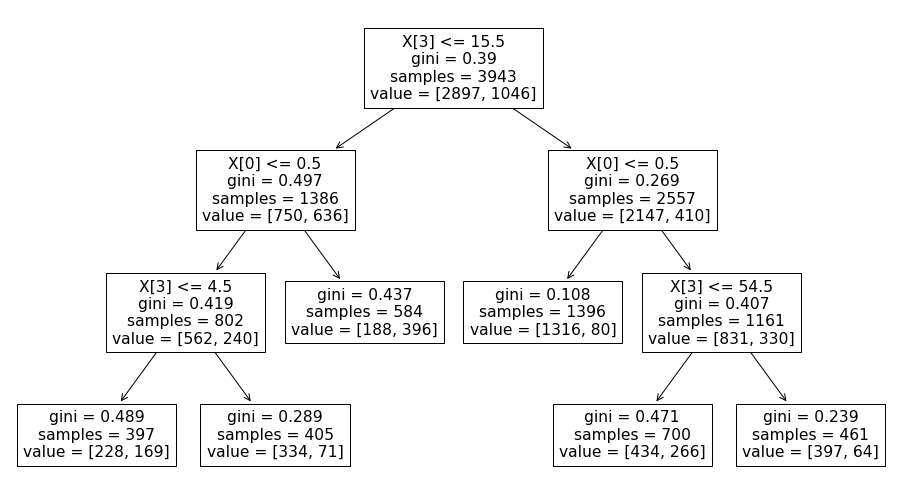

In [111]:
#Just plot the tree just to see 
#Not going to plot for other model since it just serves as an example
plt.figure(figsize=(16,9))
plot_tree(model_dtl)
plt.show()

In [117]:
#Model 2
#Same steps as above but we add some hyperparameter 
model_dt2 = DecisionTreeClassifier(max_depth=5 , max_features = 4, random_state=123)
# fit the model
model_dt2.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, max_features=4, random_state=123)

In [118]:
# look at the model scores for training set and validate set
print(f'training score: {model_dt2.score(X_train, y_train):.2%}')
print(f'validate score: {model_dt2.score(X_validate, y_validate):.2%}')

training score: 79.48%
validate score: 79.18%


In [119]:
y_pred = model_dt2.predict(X_train)

In [195]:
#Model 3
#Same steps as above but we add some hyperparameter 
model_dt3 = DecisionTreeClassifier(max_depth=2 , min_samples_split = 3, max_leaf_nodes = 4, random_state=123)
# fit the model
model_dt3.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, max_leaf_nodes=4, min_samples_split=3,
                       random_state=123)

In [196]:
# look at the model scores for training set and validate set
print(f'training score: {model_dt3.score(X_train, y_train):.2%}')
print(f'validate score: {model_dt3.score(X_validate, y_validate):.2%}')

training score: 78.75%
validate score: 79.07%


In [153]:
y_pred = model_dt3.predict(X_train)

In [191]:
#Model 4
model_dt4 = DecisionTreeClassifier(max_depth=10, max_leaf_nodes= 6, class_weight= None, random_state=123)
# fit the model
model_dt4.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, max_leaf_nodes=6, random_state=123)

In [192]:
# look at the model scores for training set and validate set
print(f'training score: {model_dt4.score(X_train, y_train):.2%}')
print(f'validate score: {model_dt4.score(X_validate, y_validate):.2%}')

training score: 78.75%
validate score: 79.07%


In [170]:
y_pred = model_dt4.predict(X_train)

In [141]:
#Model 5
model_dt5 = DecisionTreeClassifier(max_depth=4, random_state=123)
# fit the model
model_dt5.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=123)

In [142]:
# look at the model scores for training set and validate set
print(f'training score: {model_dt5.score(X_train, y_train):.2%}')
print(f'validate score: {model_dt5.score(X_validate, y_validate):.2%}')

training score: 78.90%
validate score: 79.48%


In [130]:
y_pred = model_dt5.predict(X_train)